<a href="https://colab.research.google.com/github/EziamaUgonna/Bayesian_analysis-/blob/master/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!kill -9 -1
!pip install --upgrade tf-nightly-gpu-2.0-preview tfp-nightly
!pip install --upgrade -q gspread
from tensorboardcolab import *
import shutil
#clean out the directory
shutil.rmtree('./Graph', ignore_errors=True)
os.mkdir('./Graph')
#tf.reset_default_graph()
#will start the tunneling and will print out a link:
tbc=TensorBoardColab()
%matplotlib inline  
import gc

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals 

In [3]:
# Dependencies
import os 
import warnings 
#from absl import flags 
import matplotlib 
import numpy as np 
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from __future__ import absolute_import, division, print_function, unicode_literals
#from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
#import python_utils
import tensorflow as tf 
import tensorflow_probability as tfp
tfd = tfp.distributions
#from tutorial
print("tf_version: ",tf.__version__)
print("tfp_version: ", tfp.__version__)



tf_version:  2.0.0-dev20190606
tfp_version:  0.8.0-dev20190606


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # Memory growth must be set at program startup
    print(e)


In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


In [7]:
# Read in the dataset
df = pd.read_csv('/content/gdrive/My Drive/work2.csv').astype(np.float32)
change = df.query('Speed>0').sample(frac = .1).index
df.loc[change, 'Speed'] = 0
df.loc[change, 'Class'] = 0
df.to_csv('work2.csv', header = True, index =False)
df.shape

#df.isnull().any()

(1048575, 20)

In [0]:

df = df.fillna(df.median())
df_train, df_test = train_test_split(df, test_size=0.25)
df_train = tf.keras.utils.normalize(df_train, axis=1)
df_test = tf.keras.utils.normalize(df_test, axis=1)

X = df_train.iloc[:,:-1].values
y = df_train.iloc[:,-1].values

In [0]:
original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [200, 100, 80]
latent_dim = 30
batch_size = 4
max_epochs = 800

In [0]:
#Computation of Prior 
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)


In [11]:
!pwd

/content


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 80)                32180     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_4 (Dense)              (None, 495)               15345     
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 30), (None, 30))  0         
Total params: 49,955
Trainable params: 49,955
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 200)               30780     
______________________________________

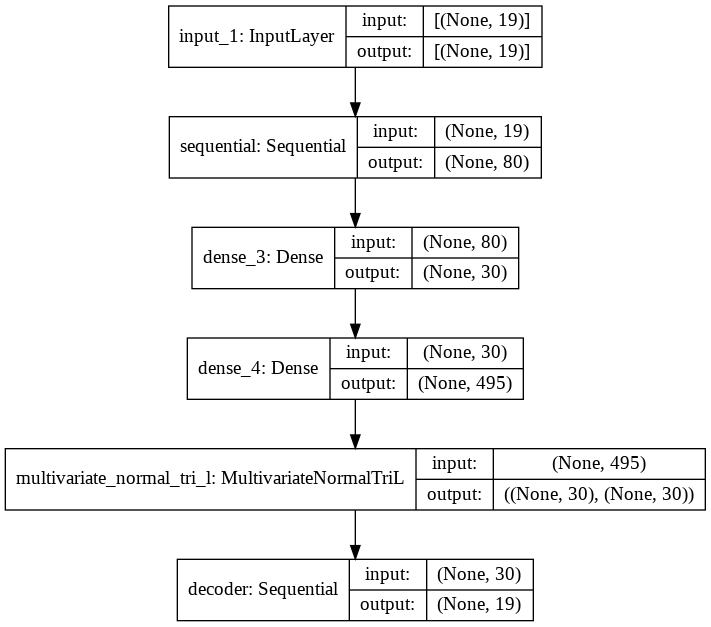

In [12]:


def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    dense_layers(intermediary_dims),
    tfkl.Dense(latent_dim, activation = 'sigmoid'),
   
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim,activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=1.0)),], name='encoder')

from keras.utils import plot_model

encoder.summary()
tf.keras.utils.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

decoder.summary()
tf.keras.utils.plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

#negative_log_likelihood= lambda x, rv_x: -rv_x.log_prob(x)


vae.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),
            loss='binary_crossentropy')

vae.summary()
tf.keras.utils.plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

In [0]:

#x_norm, x_fraud = X.values[y == 0], X.values[y == 1]
x_norm, x_fraud = X[y == 0], X[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)


In [14]:
x_norm_train_sample.shape

(80000, 19)

In [0]:
gc.collect()
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).shuffle(200, reshuffle_each_iteration =True).repeat().batch(batch_size)



tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).shuffle(200, reshuffle_each_iteration =True).repeat().batch(batch_size)


In [16]:

gc.collect()


#callbacks_list = [tf.keras.callbacks.ModelCheckpoint (filepath='bestmodel.h5', verbose=0, save_best_only=True),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005,  patience=20, verbose=0, restore_best_weights=True)]

"""callbacks_list = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
patience=1,
)"""




checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='vae.weights.best.hdf5', verbose=0, save_best_only=True)




#earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)



history = vae.fit(tf_train,
               epochs=max_epochs,steps_per_epoch=30,
               shuffle=True,
               verbose=2,
               validation_data=tf_val,validation_steps=3, callbacks=[checkpointer])




Epoch 1/800


W0607 05:28:34.031961 139951956006784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1251: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


30/30 - 3s - loss: 23.1581 - val_loss: 21.2064
Epoch 2/800
30/30 - 0s - loss: 22.4207 - val_loss: 22.5047
Epoch 3/800
30/30 - 0s - loss: 23.1897 - val_loss: 22.0938
Epoch 4/800
30/30 - 0s - loss: 21.5141 - val_loss: 20.3704
Epoch 5/800
30/30 - 0s - loss: 21.1285 - val_loss: 18.1981
Epoch 6/800
30/30 - 0s - loss: 20.3489 - val_loss: 20.7157
Epoch 7/800
30/30 - 0s - loss: 19.7397 - val_loss: 17.6806
Epoch 8/800
30/30 - 0s - loss: 19.8388 - val_loss: 16.8653
Epoch 9/800
30/30 - 0s - loss: 19.3564 - val_loss: 18.3234
Epoch 10/800
30/30 - 0s - loss: 18.5047 - val_loss: 21.7298
Epoch 11/800
30/30 - 0s - loss: 17.8945 - val_loss: 19.7110
Epoch 12/800
30/30 - 0s - loss: 17.8146 - val_loss: 21.1660
Epoch 13/800
30/30 - 0s - loss: 18.2376 - val_loss: 18.1512
Epoch 14/800
30/30 - 0s - loss: 18.9295 - val_loss: 17.5407
Epoch 15/800
30/30 - 0s - loss: 17.7050 - val_loss: 16.3978
Epoch 16/800
30/30 - 0s - loss: 17.4006 - val_loss: 17.3703
Epoch 17/800
30/30 - 0s - loss: 18.6989 - val_loss: 18.5629
E

In [0]:



reconstruct_samples_n = 100
def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

In [0]:
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
ax = plt.hist([x_log_prob[Y==0], x_log_prob[Y==1]], 60)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()

In [0]:
gc.collect()

fpr, tpr, thresh = roc_curve(Y, -x_log_prob)
auc = roc_auc_score(Y, -x_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

VAE Vs SVM 
Let's compare this with trivial supervised SVM classifier. 

In [0]:
gc.collect()

import gc
gc.collect()

from sklearn import svm 
clf =svm.SVC(gamma ='scale')
clf.fit(X,Y)
auc = roc_auc_score(Y, clf.predict(X))
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('SVM roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

Evaluation on Test Set 

In [0]:

gc.collect()


x_test_log_prob = reconstruction_log_prob(data_test.drop(['Class'], axis = 1).values, reconstruct_samples_n)
test_y = data_test["Class"].values

fpr, tpr, thresh = roc_curve(test_y, -x_test_log_prob)
auc = roc_auc_score(test_y, -x_test_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

In [0]:
gc.collect()
from tensorflow.keras import layers

import numpy as np
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve



In [0]:
gc.collect()
# create the training datasets
dx_train = tf.data.Dataset.from_tensor_slices(X_train)
# apply a one-hot transformation to each label for use in the neural network
dy_train = tf.data.Dataset.from_tensor_slices(y_train)
# zip the x and y training data together and shuffle, batch etc.
train_dataset = tf.data.Dataset.zip((dx_train, dy_train)).shuffle(500).repeat().batch(8)

In [0]:
gc.collect()
# do the same operations for the validation set
dx_valid = tf.data.Dataset.from_tensor_slices(X_test)
dy_valid = tf.data.Dataset.from_tensor_slices(y_test)
valid_dataset = tf.data.Dataset.zip((dx_valid, dy_valid)).shuffle(500).repeat().batch(30)

In [0]:
gc.collect()
def mlp_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=X_train.shape[1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layersDense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])
    return model
model1 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
model2 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
model3 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
model4 = KerasClassifier(build_fn=mlp_model, epochs=100, verbose=0)
ensemble_clf = VotingClassifier(estimators=[
    ('model1', model1), ('model2', model2), ('model3', model3),('model4', model4)])

In [0]:

gc.collect()

ensemble_clf.fit(train_dataset, epochs =100, steps_per_epoch=1000, validation_steps =3)

In [0]:
gc.collect()
y_predict = ensemble_clf.predict(X_test)
print('acc: ', accuracy_scoreecuracy_scorecuracy_score(y_pred, y_test))